In [2]:
import MPO_Net_LeNet5.LeNet5_train_v2 as LeNet5_MPO_Net

from Neural_Networks_functions.neural_networks import *

# Pre-processing

## 1. Train

In [2]:
D = 4
threshold = 90

In [3]:
# List of layer 1 weights (0-3), layer 1 bias (4), layer 2 weights (5-8), layer 2 bias (9)
weights = LeNet5_MPO_Net.main(r_1=D, r_2=D, r_3=D)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Guessing
After 0 trainning step(s),best accuracy=0
Guessing
After 0 trainning step(s),best accuracy=0
Accuracy at step 0: 0.1179
Accuracy at step 1: 0.1182
Accuracy at step 2: 0.1206
Accuracy at step 5: 0.1245
Accuracy at step 6: 0.1249
Accuracy at s

## 2. Open weights matrices into correct MPO

In [4]:
def weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site):
    """ Used specifically to convert the weights output by the MPO-Net networks into their MPO form

    Args:
        weights: List of weights matrices including biases
        sigma: List of input physical dimensions
        sigma_prime: List of output physical dimensions
        layer: Layer number (indexed from 0) such that we start at the correct weights matrix

    Returns:
        MPO: List of tensors corresponding to MPO of layer
        bias: Vector corresponding to the bias found in the list of weights
    """
    # Reshape weights, order of indices are an assumption and may need to be modified
    MPO = []
    num_sites = len(sigma)
    #starting_site = layer*(num_sites+1)  # +1 to skip bias

    for i in range(num_sites):
        # sigma'*D_right, D_left*sigma
        if i == 0:
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, sigma[i]))
            # Need shape (D_right, sigma, sigma')
            site = np.transpose(site, (1, 2, 0))
        elif i != 0 and i != num_sites-1:
            # First D is right bond, Second D is left bond
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, D, sigma[i]))
            # Need shape (D_left, D_right, sigma, sigma')
            site = np.transpose(site, (2, 1, 3, 0))
        elif i == num_sites-1:
            # First D is right bond, Second D is left bond
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, sigma[i]))
            # Need shape (D_left, sigma, sigma')
            site = np.transpose(site, (1, 2, 0))
        MPO.append(site)
    bias = weights[num_sites+starting_site]
    return MPO, bias

In [5]:
sigma = [2, 10, 10, 2]
sigma_prime = [2, 5, 6, 2]
MPO_0, bias_0 = weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site=4)

In [6]:
sigma = [2, 5, 6, 2]
sigma_prime = [2, 3, 7, 2]
MPO_1, bias_1 = weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site=9)

In [7]:
sigma = [2, 3, 7, 2]
sigma_prime = [1, 5, 2, 1]
MPO_2, bias_2 = weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site=14)

In [8]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [9]:
def LeNet5(MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2):
    """ Recreation of the FC2 network

    Args:
        MPO_0: List of tensors corresponding to MPO of 0th layer
        bias_0: Vector corresponding to bias of 0th layer
        MPO_1: List of tensors corresponding to MPO of 0th layer
        bias_1: Layer number (indexed from 0) such that we start at the correct weights matrix

    Returns:
        acc: Accuracy on test set
        t: Time to contract all layers
    """
    data = input_data.read_data_sets("./data/", validation_size=0, one_hot=True)

    start = time.time()


    for i in range(len(MPO_0)-1):
        if i == 0:
            layer_0 = con.contract_horizontal(MPO_0[i], MPO_0[i+1], 'right')
        else:
            layer_0 = con.contract_horizontal(layer_0, MPO_0[i+1], 'right')

    for i in range(len(MPO_1)-1):
        if i == 0:
            layer_1 = con.contract_horizontal(MPO_1[i], MPO_1[i+1], 'right')
        else:
            layer_1 = con.contract_horizontal(layer_1, MPO_1[i+1], 'right')

    for i in range(len(MPO_2)-1):
        if i == 0:
            layer_2 = con.contract_horizontal(MPO_2[i], MPO_2[i+1], 'right')
        else:
            layer_2 = con.contract_horizontal(layer_2, MPO_2[i+1], 'right')

    end = time.time()

    total = 1000
    correct = 0        
    for i in range(0, total):
        # Must do this otherwise performance of inputs.eval() decays quickly
        # Massive speed up by reseting graph and session each time
        tf.compat.v1.reset_default_graph()
        with tf.compat.v1.Session() as sess:
            time0 = time.time()
            W_conv1 = weights[0]
            b_conv1 = weights[1]
            x_image = tf.reshape(data.test.images[i], [-1, 28, 28, 1])
            # 28x28x1
            h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
            # 28x28x6
            h_pool1 = max_pool_2x2(h_conv1)
            # 14x14x6
            W_conv2 = weights[2]
            b_conv2 = weights[3]
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            # 10x10x16
            h_pool2 = max_pool_2x2(h_conv2)
            # 5x5x16
            inputs = tf.reshape(h_pool2,[-1,400])
            out = inputs.eval()
            time1 = time.time()
            #if i % 100 == 0:
                #print(time1 - time0)
        xW = act.ReLU(out @ layer_0 + bias_0)
        xW = act.ReLU(xW @ layer_1 + bias_1)
        result = xW @ layer_2 + bias_2
        index = result.argmax()
        if index == list(data.test.labels[i]).index(1):
            correct += 1
        
    acc = correct/total*100
    t = end-start
    return acc, t

In [10]:
acc, t = LeNet5(MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2)
print(acc)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
87.8


## 4. Close legs to use for compression algorithm

In [11]:
MPS_0 = close_legs(MPO_0)
MPS_1 = close_legs(MPO_1)
MPS_2 = close_legs(MPO_2)

## 5. Compress MPS layers

In [12]:
compressed_MPS_0, dist, sim = compress_layer(MPS_0, phys_dim=[4, 50, 60, 4], threshold=1e-8, plot=0)
compressed_MPS_0.append(MPS_0)
compressed_MPS_1, dist, sim = compress_layer(MPS_1, phys_dim=[4, 15, 42, 4], threshold=1e-8, plot=0)
compressed_MPS_1.append(MPS_1)
compressed_MPS_2, dist, sim = compress_layer(MPS_2, phys_dim=[2, 15, 14, 2], threshold=1e-8, plot=0)
compressed_MPS_2.append(MPS_2)

Sim: 50.0444352499548 Dist: 13.093499384312748 BondDim: 1
Sim: 143.71342179907313 Dist: 8.818771999427128 BondDim: 2
Sim: 190.89648649723492 Dist: 5.530612523013913 BondDim: 3
Sim: 19.719163084443107 Dist: 10.926096823585693 BondDim: 1
Sim: 71.615571015236 Dist: 8.214814901601653 BondDim: 2
Sim: 119.12989742265175 Dist: 4.468652756722176 BondDim: 3
Sim: 23.575871235169863 Dist: 7.737647964696528 BondDim: 1
Sim: 59.7306653510816 Dist: 4.869948861092959 BondDim: 2
Sim: 76.18394301519963 Dist: 2.6950184128392545 BondDim: 3


In [13]:
print("Orig:", calculate_params(MPS_0))
for i in range(len(compressed_MPS_0)):
    print(i+1, round(calculate_params(compressed_MPS_0[i])/calculate_params(MPS_0)*100, 2), "% of Orig")

Orig: 1792
1 6.58 % of Orig
2 25.45 % of Orig
3 56.58 % of Orig
4 100.0 % of Orig


In [14]:
print("Orig:", calculate_params(MPS_1))
for i in range(len(compressed_MPS_1)):
    print(i+1, round(calculate_params(compressed_MPS_1[i])/calculate_params(MPS_1)*100, 2), "% of Orig")

Orig: 944
1 6.89 % of Orig
2 25.85 % of Orig
3 56.89 % of Orig
4 100.0 % of Orig


In [15]:
print("Orig:", calculate_params(MPS_2))
for i in range(len(compressed_MPS_2)):
    print(i+1, round(calculate_params(compressed_MPS_2[i])/calculate_params(MPS_2)*100, 2), "% of Orig")

Orig: 480
1 6.88 % of Orig
2 25.83 % of Orig
3 37.92 % of Orig
4 100.0 % of Orig


# Accuracy Tests

In [16]:
def test_overall_accuracy_LeNet5(compressed_MPS_0, compressed_MPS_1, compressed_MPS_2, MPO_0_orig, bias_0, MPO_1_orig, bias_1, MPO_2_orig, bias_2, sigma_0, sigma_1, sigma_2, sigma_3, layer):
    acc_compressed = []
    time_compressed = []
    params = []



    for new_dim in range(1, len(compressed_MPS_0)+1):
        if layer == 0:
            MPS_0 = compressed_MPS_0[new_dim-1]
            MPS_1 = compressed_MPS_1[-1]
            MPS_2 = compressed_MPS_2[-1]
        elif layer == 1:
            MPS_0 = compressed_MPS_0[-1]
            MPS_1 = compressed_MPS_1[new_dim-1]
            MPS_2 = compressed_MPS_2[-1]
        elif layer == 2:
            MPS_0 = compressed_MPS_0[-1]
            MPS_1 = compressed_MPS_1[-1]
            MPS_2 = compressed_MPS_2[new_dim-1]

        dim_0 = [MPS_0[0].shape[1], MPS_0[1].shape[1], MPS_0[2].shape[1], MPS_0[3].shape[1]]
        dim_1 = [MPS_1[0].shape[1], MPS_1[1].shape[1], MPS_1[2].shape[1], MPS_1[3].shape[1]]
        dim_2 = [MPS_2[0].shape[1], MPS_2[1].shape[1], MPS_2[2].shape[1], MPS_2[3].shape[1]]
        MPO_0 = open_legs(MPS_0, sigma_0, sigma_1, bond_dim=dim_0)
        MPO_1 = open_legs(MPS_1, sigma_1, sigma_2, bond_dim=dim_1)
        MPO_2 = open_legs(MPS_2, sigma_2, sigma_3, bond_dim=dim_2)

        total_params = 0
        for tensor in MPO_0:
            total_params += tensor.size
        for tensor in MPO_1:
            total_params += tensor.size
        for tensor in MPO_2:
            total_params += tensor.size
        params.append(total_params)

        acc, t = LeNet5(MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2)
        acc_compressed.append(acc)
        time_compressed.append(t)

    params_orig = 0
    for tensor in MPO_0_orig:
        params_orig += tensor.size
    for tensor in MPO_1_orig:
        params_orig += tensor.size
    for tensor in MPO_2_orig:
        params_orig += tensor.size

    acc_orig, time_orig = LeNet5(MPO_0_orig, bias_0, MPO_1_orig, bias_1, MPO_2_orig, bias_2)

    x = range(1, len(compressed_MPS_0)+1)
    loss = [acc_orig-x for x in acc_compressed]
    params = np.array(params)/params_orig*100


    data1 = acc
    data2 = params

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Compressed Dimension')
    ax1.set_ylabel('Loss [%]', color=color)
    #ax1.plot(x, acc_compressed, color=color)
    ax1.plot(x, loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(acc_orig, color='r', linestyle='--')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Compression [%]', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, params, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Loss vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_0)))

    fig.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(x, time_compressed)
    plt.title('Contraction Time vs. Compressed Dimension')
    plt.xlabel('Time [s]')
    plt.ylabel('Compressed Dimension')
    plt.axhline(time_orig, color='r', linestyle='--')

## 1. Accuracy when compressing first layer

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


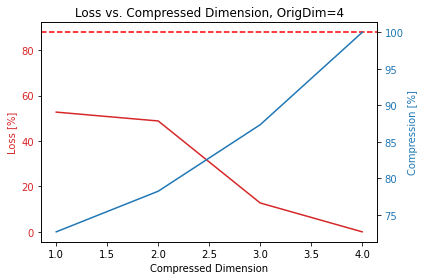

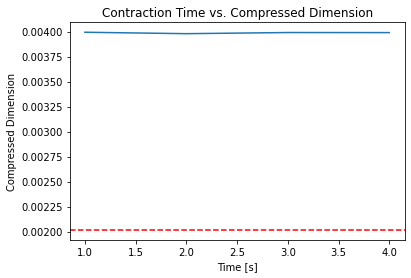

In [18]:
test_overall_accuracy_LeNet5(compressed_MPS_0, compressed_MPS_1, compressed_MPS_2, MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2, sigma_0, sigma_1, sigma_2, sigma_3,
                             layer=1)

## 2. Accuracy when compressing second layer

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


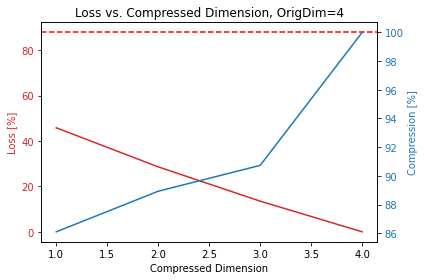

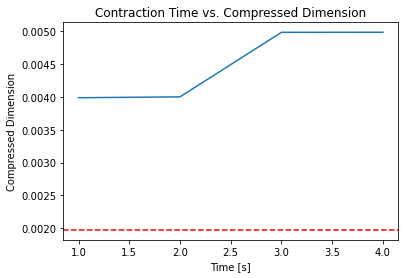

In [19]:
test_overall_accuracy_LeNet5(compressed_MPS_0, compressed_MPS_1, compressed_MPS_2, MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2, sigma_0, sigma_1, sigma_2, sigma_3,
                             layer=2)

# Optimizing Bond Dimensions

In [33]:
### Optimized path
# 1. Starting state
# 2. Compress all layers down by 1
# 3. Calculate delta_params in all directions
# 4. Calculate delta_acc in all directions
# 5. Moved based on minimizing delta_acc/delta_params

sigma_0 = [2, 10, 10, 2]
sigma_1 = [2, 5, 6, 2]
sigma_2 = [2, 3, 7, 2]
sigma_3 = [1, 5, 2, 1]

MPO_0, bias_0 = weights_to_MPO_mod(weights, D, sigma_0, sigma_1, starting_site=4)
MPO_1, bias_1 = weights_to_MPO_mod(weights, D, sigma_1, sigma_2, starting_site=9)
MPO_2, bias_2 = weights_to_MPO_mod(weights, D, sigma_2, sigma_3, starting_site=14)
layers = [MPO_0, MPO_1, MPO_2]

acc_orig, t = LeNet5(MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2)
threshold = 5
last_updated = np.ones(len(layers))
loss = 0
while True:
    print(loss)
    # 1. Starting state
    MPS_0 = close_legs(layers[0])
    MPS_1 = close_legs(layers[1])
    MPS_2 = close_legs(layers[2])

    # 2. Compress all layers down by 1
    dim0 = MPS_0[math.ceil(len(MPS_0)/2)].shape[0]
    dim1 = MPS_1[math.ceil(len(MPS_1)/2)].shape[0]
    dim2 = MPS_2[math.ceil(len(MPS_1)/2)].shape[0]

    if last_updated[0] == 1:
        compressed_0, _, _ = compress_layer_single_dim(MPS_0, phys_dim=[4,50,60,4], threshold=1e-6, compressed_dim=dim0-1)
        bonds0 = [compressed_0[0].shape[1], compressed_0[1].shape[1], compressed_0[2].shape[1], compressed_0[3].shape[1]]
        new_MPO_0 = open_legs(compressed_0, sigma=sigma_0, sigma_prime=sigma_1, bond_dim=bonds0)
    if last_updated[1] == 1:
        compressed_1, _, _ = compress_layer_single_dim(MPS_1, phys_dim=[4,15,42,4], threshold=1e-6, compressed_dim=dim1-1)
        bonds1 = [compressed_1[0].shape[1], compressed_1[1].shape[1], compressed_1[2].shape[1], compressed_1[3].shape[1]]
        new_MPO_1 = open_legs(compressed_1, sigma=sigma_1, sigma_prime=sigma_2, bond_dim=bonds1)
    if last_updated[2] == 1:
        compressed_2, _, _ = compress_layer_single_dim(MPS_2, phys_dim=[2,15,14,2], threshold=1e-6, compressed_dim=dim2-1)
        bonds2 = [compressed_2[0].shape[1], compressed_2[1].shape[1], compressed_2[2].shape[1], compressed_2[3].shape[1]]
        new_MPO_2 = open_legs(compressed_2, sigma=sigma_2, sigma_prime=sigma_3, bond_dim=bonds2)
    MPOs = [new_MPO_0, new_MPO_1, new_MPO_2]

    # 3. Calculate delta_params
    delta_params0 = calculate_params(MPO_0) - calculate_params(new_MPO_0)
    delta_params1 = calculate_params(MPO_1) - calculate_params(new_MPO_1)
    delta_params2 = calculate_params(MPO_2) - calculate_params(new_MPO_2)
    new_params = [delta_params0, delta_params1, delta_params2]
    # 4. Calculate delta_acc
    new_acc0, _ = LeNet5(new_MPO_0, bias_0, layers[1], bias_1, layers[2], bias_2)
    new_acc1, _ = LeNet5(layers[0], bias_0, new_MPO_1, bias_1, layers[2], bias_2)
    new_acc2, _ = LeNet5(layers[0], bias_0, layers[1], bias_1, new_MPO_2, bias_2)

    new_acc = [new_acc0, new_acc1, new_acc2]

    new_loss = [acc_orig-new_acc0, acc_orig-new_acc1, acc_orig-new_acc2]
    print(new_loss)
    for i, loss in enumerate(new_loss):
        if loss > threshold:
            new_loss[i] = np.inf
    delta_loss0 = loss - new_loss[0]
    delta_loss1 = loss - new_loss[1]
    delta_loss2 = loss - new_loss[2]

    #print(new_acc)
    #delta_acc0 = acc - new_acc0
    #delta_acc1 = acc - new_acc1
    #delta_acc2 = acc - new_acc2

    # 5. Calculate slope
    #slope = [delta_acc0/delta_params0, delta_acc1/delta_params1, delta_acc2/delta_params2]
    slope = [new_loss[0]/new_params[0], new_loss[1]/new_params[1], new_loss[2]/new_params[2]]

    for i, loss in enumerate(new_loss):
        if loss > threshold:
            slope[i] = np.inf
        
    # 6. Find minimum slope
    index = np.argmin(slope)

    # 7. Update layers
    if new_loss[0] > threshold and new_loss[1] > threshold and new_loss[2] > threshold:
        break
    else:
        layers[index] = MPOs[index]
        loss = new_loss[index]
        #acc = new_acc[index]
        last_updated = np.zeros(len(layers))
        last_updated[index] = 1
        print(last_updated)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0
Sim: 190.8964772203517 Dist: 5.530613361698814 BondDim: 3
Sim: 119.12989665037651 Dist: 4.468652843132478 BondDim: 3
Sim: 76.18394226375139 Dist: 2.695018552253543 BondDim: 3
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
[14.5, 12.700000000000003, 13.5]


In [34]:
acc, _ = LeNet5(layers[0], bias_0, layers[1], bias_1, layers[2], bias_2)
print(acc_orig-acc)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0.0


In [29]:
print(acc)

87.8


In [30]:
dim0 = layers[0][math.ceil(len(layers[0])/2)].shape[0]
dim1 = layers[1][math.ceil(len(layers[1])/2)].shape[0]
dim2 = layers[2][math.ceil(len(layers[2])/2)].shape[0]
print(dim0, dim1, dim2)

4 4 4


In [31]:
### Params compared to trained MPO model
orig_params = calculate_params(MPO_0) + calculate_params(MPO_1) + calculate_params(MPO_2)
params = calculate_params(layers[0]) + calculate_params(layers[1]) + calculate_params(layers[2])
print(round(params/orig_params*100, 2), "%")

100.0 %


In [32]:
### Params compared to typical model
orig_params = 400*120 + 120*88 + 88*10
params = calculate_params(layers[0]) + calculate_params(layers[1]) + calculate_params(layers[2])
print(round(params/orig_params*100, 2), "%")

5.41 %


In [33]:
### Permutations
# 1. Starting state
# 2. Compress single layer down until threshold
# 3. Switch layers

sigma = [4, 7, 7, 4]
sigma_prime = [4, 4, 4, 4]
MPO_0, bias_0 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=0)

sigma = [4, 4, 4, 4]
sigma_prime = [1, 10, 1, 1]
MPO_1, bias_1 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=1)

layers = [MPO_0, MPO_1]

acc, _ = FC2(MPO_0, bias_0, MPO_1, bias_1)
threshold = 90
last_updated = np.ones(len(layers))

print(acc)
# 1. Starting state
MPS_0 = close_legs(layers[0])
MPS_1 = close_legs(layers[1])

# 2. Compress single layer down until acc less than threshold
dim0 = MPS_0[math.ceil(len(MPS_0)/2)].shape[0]
dim1 = MPS_1[math.ceil(len(MPS_1)/2)].shape[0]

layer_to_compress = 1
for i in range(len(layers)):
    if layer_to_compress == 0:
        while True:
            compressed_0, _, _ = compress_layer_single_dim(MPS_0, phys_dim=[16,28,28,16], threshold=1e-6, compressed_dim=dim0-1)
            bonds0 = [compressed_0[0].shape[1], compressed_0[1].shape[1], compressed_0[2].shape[1], compressed_0[3].shape[1]]
            new_MPO = open_legs(compressed_0, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=bonds0)
            new_acc, _ = FC2(new_MPO, bias_0, layers[1], bias_1)
            print(new_acc)
            if new_acc < threshold:
                layer_to_compress = 1
                break
            else:
                layers[layer_to_compress] = new_MPO
                dim0 = dim0-1

    elif layer_to_compress == 1:
        while True:
            compressed_1, _, _ = compress_layer_single_dim(MPS_1, phys_dim=[4,40,4,4], threshold=1e-6, compressed_dim=dim1-1)
            bonds1 = [compressed_1[0].shape[1], compressed_1[1].shape[1], compressed_1[2].shape[1], compressed_1[3].shape[1]]
            new_MPO = open_legs(compressed_1, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=bonds1)
            new_acc, _ = FC2(layers[0], bias_0, new_MPO, bias_1)
            print(new_acc)
            if new_acc < threshold:
                layer_to_compress = 0
                break
            else:
                layers[layer_to_compress] = new_MPO
                dim1 = dim1-1

ValueError: cannot reshape array of size 150 into shape (4,4,4)